In [1]:
""" Import Required Libraries"""
#!pip3 install imutils
from tensorflow import keras
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from google.colab import drive
from imutils import perspective
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow
import pickle
import imutils
import imutils.perspective as persp #order the contour coordinates (left,right. top, bottom)
import time
from time import sleep
import os # for folder navigation
drive.mount('/content/drive')

Mounted at /content/drive


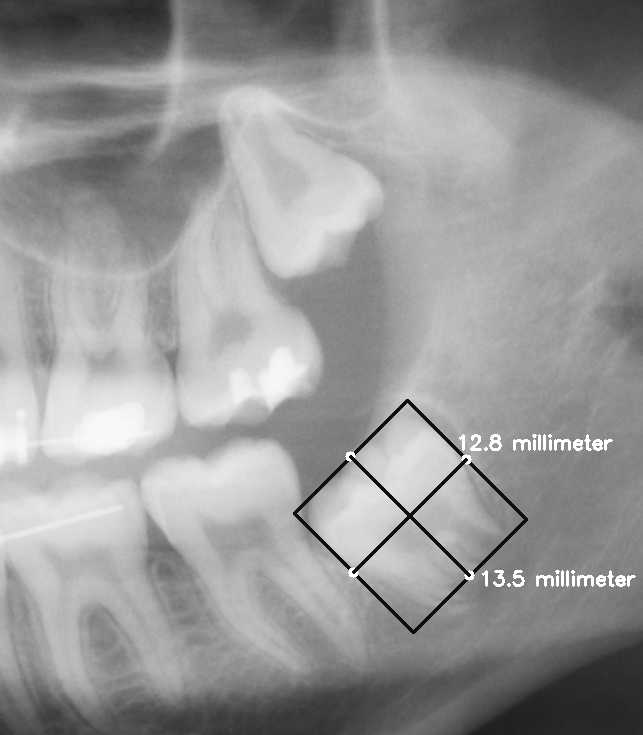

In [4]:

#ALL STEPS COMBINED

#***************************************************************************************
#PART 1    - Lower Left Third Molar(LLTM) Extraction
#***************************************************************************************
#Making prediction using the trained models

#loading the model
model = keras.models.load_model('model.h5', compile=False)

#Read a single image and perform image pre-processing
test_img = cv2.imread('image path', cv2.IMREAD_GRAYSCALE)
orig_step1= test_img
test_img = cv2.resize(test_img, (512, 256))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BAYER_GR2GRAY)
test_img = np.expand_dims(test_img, axis=0)

#Make prediction
prediction = model.predict(test_img)>0.5

#View predicted image
prediction_image = prediction.reshape(256,512)

#new added steps to convert predicted image from bool to unit8 before passing it to the next step - and change to 3 channels
img3 = prediction_image.astype("uint8")

img2 = np.zeros( ( np.array(img3).shape[0], np.array(img3).shape[1], 3 ) )#
img2[:,:,0] = img3 # same value in each channel
img2[:,:,1] = img3
img2[:,:,2] = img3
img2 = img2.astype("uint8")

#***************************************************************************************
#PART 2   - Draw measurements on the original image using the extracted LLTM 
#***************************************************************************************
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
# Load in image, convert to gray scale, and Otsu's threshold

def Draw_Measurements(orig_image,predict_image,erode_iteration,open_iteration):
    kernel1 =( np.ones((5,5), dtype=np.float32))
    kernel_sharpening = np.array([[-1,-1,-1], 
                                  [-1,9,-1], 
                                 [-1,-1,-1]])
    image = predict_image
    image2 =orig_image    
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel1,iterations=open_iteration )
    image = cv2.filter2D(image, -1, kernel_sharpening)
    image = cv2.erode(image,kernel1,iterations =erode_iteration)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    labels = cv2.connectedComponents(thresh,connectivity=8)[1]       
    a = np.unique(labels)
    count2=0
    for label in a:
        if label == 0:
            continue

        # Create a mask
        mask = np.zeros(thresh.shape, dtype="uint8")
        mask[labels == label] = 255
        # Find contours and determine contour area
        cnts,hieararch = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0]
        c_area = cv2.contourArea(cnts)
        # threshhold for tooth count
        if c_area>2000:
            count2+=1
        
        (x,y),radius = cv2.minEnclosingCircle(cnts)
        rect = cv2.minAreaRect(cnts)
        box = cv2.boxPoints(rect)
        box = np.array(box, dtype="int")    
        box = perspective.order_points(box)
        color1 = (list(np.random.choice(range(150), size=3)))  
        color =[int(color1[0]), int(color1[1]), int(color1[2])]  
        cv2.drawContours(image2,[box.astype("int")],0,color,2)
        (tl,tr,br,bl)=box
        
        (tltrX,tltrY)=midpoint(tl,tr)
        (blbrX,blbrY)=midpoint(bl,br)
    	# compute the midpoint between the top-left and top-right points,
    	# followed by the midpoint between the top-righ and bottom-right
        (tlblX,tlblY)=midpoint(tl,bl)
        (trbrX,trbrY)=midpoint(tr,br)
    	# draw the midpoints on the image
        cv2.circle(image2, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(image2, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(image2, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(image2, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
        cv2.line(image2, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),color, 2)
        cv2.line(image2, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),color, 2)
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
       
        global dimA
        dimA = dA*0.08
        global dimB
        dimB = dB*0.08
        cv2.putText(image2, "{:.1f} millimeter".format(dimA),(int(tltrX - 10), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255,255,255), 2)
        cv2.putText(image2, "{:.1f} millimeter".format(dimB),(int(trbrX + 10), int(trbrY+10)), cv2.FONT_HERSHEY_SIMPLEX,0.65,(255,255,255), 2)
    teeth_count=count2
    return image2,teeth_count

#***************************************************************************************
#PART 3   - Show Result
#***************************************************************************************
predicted = cv2.resize(img2, (orig_step1.shape[1],orig_step1.shape[0]), interpolation=cv2.INTER_LANCZOS4)
meas_result,teeth_count=Draw_Measurements(orig_step1,predicted,3,2)

#cv2_imshow(meas_result) # show image with measurement without cropping

cropped = orig_step1[400:(meas_result.shape[0]-300),1900:(meas_result.shape[1]-400)]
cv2_imshow(cropped)


Useful References:
*   https://www.youtube.com/watch?v=DFFQM6Zm-8c
*   https://www.scantips.com/lights/subjectdistance.html


*   https://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

*   https://www.youtube.com/watch?v=_XQoITOJUd8&t=560s 